In [1]:
import numpy as np, pandas as pd
import os, re
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import ElasticNet
from rdkit import Chem
from matplotlib import pyplot as plt

In [69]:
from scripts.utils import dictEndpoint

In [3]:
def dropZeroColumns(df):
    mask=(df != 0).any(axis=0)
    return df.loc[:,mask]

In [3]:
allEmbeddings = [data for data in  os.listdir("embeddings") if not data.startswith(".") and not "epoch0" in data]
allFP=[data for data in  os.listdir("FPs") if not data.startswith(".")]
allData = [data for data in  os.listdir("data") if not data.startswith(".") and ".csv" in data]

In [4]:
patternNames = '^(?P<name>[a-zA-Z]+)_[a-zA-Z]+\.(?P<format>[a-zA-Z]+)$'
compiler = re.compile(patternNames)

In [7]:
idxDir = "intraDomainIdxs"
idxs = { endpoint : np.loadtxt(f"{idxDir}/{endpoint}_idxs.txt", dtype=int)
             for endpoint in dictEndpoint }

In [12]:
## y = embeddings; shape = N mols
embeddingDir = "embeddings"
Ys = {endpoint: pd.read_csv(f"{embeddingDir}/{endpoint}_embedding.csv", names=["y1","y2"], header=0)
        for endpoint in dictEndpoint
}

In [14]:
## x = bit of FP; shape = ...
fpDir = "FPs"
Xs = {endpoint: dropZeroColumns(pd.read_csv(f"{fpDir}/{endpoint}_FP.csv", header=None).iloc[idxs[endpoint]])
    for endpoint in dictEndpoint
}

In [15]:
dataDir = "data"
data = {endpoint: pd.read_csv(f"{dataDir}/{endpoint}_dataset.csv").iloc[idxs[endpoint]]
        for endpoint in dictEndpoint
}

In [16]:
smis ={k:v["SMILES"] for k,v in data.items() }
labels = {k:v["Label"] for k,v in data.items() }

In [17]:
labels["hepa"].value_counts()

Label
1    282
0    254
Name: count, dtype: int64

In [18]:
sizes = {endpoint:len(df) for endpoint,df in Ys.items() }

In [19]:
sizes

{'devtox': 584,
 'carcino': 642,
 'andro': 1417,
 'estro': 1292,
 'muta': 540,
 'skin': 235,
 'chrom': 387,
 'hepa': 536}

## Linear Regression

In [22]:
from sklearn.linear_model import Lasso

In [23]:
def linearFitToYandCoeff(x,y, regressor):
    regressor.fit(x,y)
    yPred=regressor.predict(x)
    return yPred, regressor.coef_

In [24]:
coeffs = {endpoint:pd.DataFrame(columns=["coef1","coef2"], index=range(bits.shape[1]))
         for endpoint,bits in Xs.items()}
for endpoint,x in Xs.items() :
    Y = Ys[endpoint]

    for num,y in enumerate(Y[["y1","y2"]].T.values):
        yPred, coeff = linearFitToYandCoeff(x,y, regressor=Lasso(alpha=.001,)
                                           )
        
        Ys[endpoint] = pd.concat(
                            [Ys[endpoint],pd.DataFrame(yPred,columns=["y"+str(num+1)+"pred"])],
                                 axis=1, ignore_index=False)
        coeffs[endpoint].iloc[:,num]=coeff

/home/tox/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.269e+00, tolerance: 2.337e-02
  model = cd_fast.enet_coordinate_descent(
/home/tox/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.357e+00, tolerance: 2.220e-02
  model = cd_fast.enet_coordinate_descent(
/home/tox/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.577e-01,

In [25]:
from sklearn.metrics import r2_score

In [26]:
## r^2 goodness fit
r2 = {
    endpoint:[r2_score(
                *Ys[endpoint][[f"y{num}",f"y{num}pred"]].T.values
                    )  
        for num in ["1","2"] ]
    for endpoint in Xs.keys()
}

In [27]:
r2

{'devtox': [0.9590722145560647, 0.9608567912220863],
 'carcino': [0.952773868929239, 0.9526389909851898],
 'andro': [0.941789984985847, 0.9371391828250313],
 'estro': [0.8845320875308618, 0.9137788837522031],
 'muta': [0.9566908802738266, 0.9534536607986412],
 'skin': [0.9726159595735873, 0.9725353782966534],
 'chrom': [0.9731747456744947, 0.9750529670792314],
 'hepa': [0.9853466709140276, 0.9860064680553636]}

In [28]:
## statistical test
from scipy import stats

In [29]:
pvals={
    endpoint:stats.spearmanr(
                *coeffs[endpoint].abs().T.astype(float).values, alternative="greater"
                    )
    for endpoint in Xs.keys()
}

In [30]:
pvals

{'devtox': SignificanceResult(statistic=0.8593642457605024, pvalue=0.0),
 'carcino': SignificanceResult(statistic=0.8757733536092475, pvalue=0.0),
 'andro': SignificanceResult(statistic=0.8778683765851595, pvalue=0.0),
 'estro': SignificanceResult(statistic=0.703148724421134, pvalue=1.1935422761823206e-305),
 'muta': SignificanceResult(statistic=0.4607667797331474, pvalue=1.798399830014433e-108),
 'skin': SignificanceResult(statistic=0.7524692824552881, pvalue=0.0),
 'chrom': SignificanceResult(statistic=0.8023349512713872, pvalue=0.0),
 'hepa': SignificanceResult(statistic=0.6886717045876334, pvalue=2.8089580839427363e-288)}

In [74]:
resultsR2scores=pd.DataFrame.from_dict(
    {nameEndpoint:r2[endpoint] for endpoint,nameEndpoint in dictEndpoint.items()}, orient='index',
    columns=["r$^2$ embedding 1","r$^2$ embedding 2"]
).round(2)
resultsR2scores.index.name="Endpoint"

In [75]:
resultsR2scores

,r$^2$ embedding 1,r$^2$ embedding 2
Endpoint,,
Chromosomal aberration,0.97,0.98
Mutagenicity,0.96,0.95
Carcinogenicity,0.95,0.95
Developmental toxicity,0.96,0.96
Skin irritation,0.97,0.97
Estrogenicity,0.88,0.91
Androgenicity,0.94,0.94
Hepatoxicity,0.99,0.99


In [37]:
idxsAbsSorted = {
    endpoint:
    np.argsort(coef["coef1"].abs().to_numpy(copy=True))[::-1]
    for endpoint,coef in coeffs.items()
}

idxsSorted = {
    endpoint:
    np.argsort(coef["coef1"].to_numpy(copy=True))[::-1]
    for endpoint,coef in coeffs.items()
}

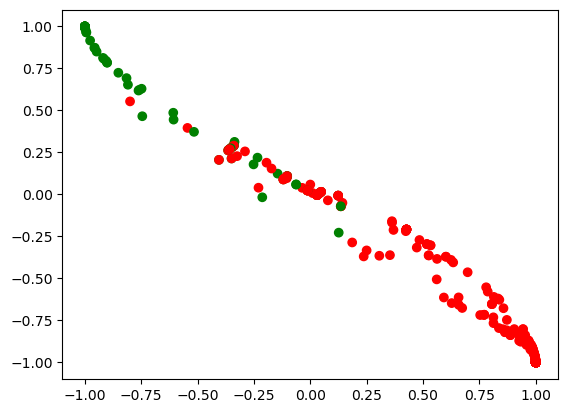

In [38]:
tmpEnd = "devtox"
tmpLab = labels[tmpEnd]
colors = tmpLab.apply(lambda x: "red" if x==1 else "green")
plt.scatter(*Ys[tmpEnd][["y1","y2"]].values.T, c=colors)

In [40]:
# In figure x axis = y1 so "coef1" sign for each endpoint follows toxicity or non toxicity
toxSign = {
    "carcino":-1, "devtox":+1, "hepa":+1, "skin":+1, "chrom":+1, "andro":-1, "muta":-1, "estro":+1,
}

In [41]:
bitsSorted = {endpoint:
    Xs[endpoint].columns.to_numpy(copy=True)[idxs]\
    if toxSign[endpoint]>0 else\
    Xs[endpoint].columns.to_numpy(copy=True)[idxs][::-1]
    for endpoint, idxs in idxsSorted.items()
}

In [49]:
bitsSorted

{'devtox': array([1542,  136,  940, ...,  563,  194,  101]),
 'carcino': array([1883,  429, 1072, ...,  240, 1363,  827]),
 'andro': array([1597,  776, 1267, ...,  744,  681, 1253]),
 'estro': array([1103,  905, 1342, ..., 1855, 1025, 1433]),
 'muta': array([1154, 1883,  283, ...,  384,  817, 1907]),
 'skin': array([1727,   20, 1185, ...,  311,  499,  976]),
 'chrom': array([2031, 1903, 1523, ..., 1122, 1370, 1622]),
 'hepa': array([1587, 1795, 1142, ..., 1119, 1231, 1105])}

In [56]:
tableBits = pd.concat([
    pd.DataFrame( df, columns=[dictEndpoint[endpoint]] )
for endpoint,df in bitsSorted.items() ], ignore_index=False, axis=1)

# rdkit bits vs relative frequency correlation

## Bit prediction

In [42]:
def predictBit(endpoint, idx, type: int):

    xEnd = Xs[endpoint]
    mask0 = labels[endpoint]==0
    mask1 = labels[endpoint]==1

    if type == 1:
        countNoTox_1=xEnd[mask0][idx].sum() # bit presente nelle molecole non tossiche
        countTox_1=xEnd[mask1][idx].sum() # bit presente nelle molecole tossiche
    
        countW_NoTox_1=countNoTox_1*(mask1.sum()/sizes[endpoint])
        countW_Tox_1=countTox_1*(mask0.sum()/sizes[endpoint])
    
        score = score_Tox_1 = countW_Tox_1/(countW_Tox_1+countW_NoTox_1)

    
    elif type == 0:

        countNoTox_0 = (1-xEnd[mask0][idx] ).sum() # bit assente nelle molecole non tossiche
        countTox_0 = (1-xEnd[mask1][idx] ).sum() # bit assente nelle molecole tossiche
        
        countW_NoTox_0=countNoTox_0*(mask1.sum()/sizes[endpoint])
        countW_Tox_0=countTox_0*(mask0.sum()/sizes[endpoint])
    
        score = score_NoTox_0 = countW_NoTox_0/(countW_NoTox_0+countW_Tox_0)

    return score

In [43]:
maxBitsToPred = 30
scoresPresence={}
scoresAbsence={}

for endpoint, bits in bitsSorted.items():
    scoresPresence[endpoint]=[  predictBit(endpoint, bit, 1) for bit in bits[:maxBitsToPred] ]
    scoresAbsence[endpoint]=[  predictBit(endpoint, bit, 0) for bit in bits[:maxBitsToPred] ]

scoresPresence=pd.DataFrame(scoresPresence)
scoresAbsence=pd.DataFrame(scoresAbsence)

In [176]:
scoresAbsence.describe()

,devtox,carcino,muta,skin,andro,estro,chrom,hepa
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.474498,0.526441,0.513128,0.518444,0.575291,0.567577,0.522365,0.522113
std,0.050126,0.016477,0.030313,0.028193,0.034308,0.073305,0.021334,0.021159
min,0.359135,0.500941,0.459036,0.448776,0.523045,0.484481,0.480936,0.443442
25%,0.443284,0.515269,0.497900,0.502518,0.544859,0.524657,0.510433,0.515482
50%,0.481334,0.522418,0.503466,0.510970,0.570382,0.552799,0.516694,0.526119
75%,0.515053,0.539586,0.518745,0.536658,0.597552,0.580127,0.527053,0.534728
max,0.544502,0.561363,0.611958,0.597484,0.666147,0.835598,0.586152,0.565751


In [175]:
scoresPresence.describe()

,devtox,carcino,muta,skin,andro,estro,chrom,hepa
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.479194,0.634180,0.545347,0.613812,0.703283,0.644256,0.601504,0.536914
std,0.090886,0.083030,0.087460,0.134357,0.055597,0.089726,0.072404,0.027112
min,0.297033,0.506147,0.379187,0.321608,0.578444,0.436216,0.437121,0.478998
25%,0.411583,0.579104,0.490471,0.550631,0.670228,0.593407,0.556211,0.515275
50%,0.459315,0.629283,0.519246,0.605925,0.709838,0.652889,0.591109,0.539132
75%,0.533815,0.674680,0.625809,0.711327,0.742057,0.702802,0.636927,0.557904
max,0.705751,0.809295,0.734669,0.864865,0.797971,0.800675,0.736607,0.582211


In [168]:
predsAbsence=scoresAbsence.map(lambda x: 1 if x>=.5 else 0)
predsPresence=scoresPresence.map(lambda x: 1 if x>=.5 else 0)

In [169]:
metricPresence = predsPresence.mean(axis=0)
metricAbsence = predsAbsence.mean(axis=0)

In [137]:
for endpoint, df in labels.items():
    print(endpoint, df.value_counts())

devtox Label
1    498
0     86
Name: count, dtype: int64
carcino Label
0    404
1    238
Name: count, dtype: int64
estro Label
0    1210
1      82
Name: count, dtype: int64
muta Label
1    276
0    264
Name: count, dtype: int64
andro Label
0    1247
1     170
Name: count, dtype: int64
skin Label
0    160
1     75
Name: count, dtype: int64
chrom Label
0    210
1    177
Name: count, dtype: int64
hepa Label
1    282
0    254
Name: count, dtype: int64
